In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplin
import math
from scipy.sparse.linalg import spsolve
import pandas as pd
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=400,precision=10,suppress=True)

L'objectif de ce TP est de programmer la méthode des éléments finis (1D) pour résoudre l'équation elliptique avec conditions aux limites de Dirichlet:

$-u''(x) + u(x) = f(x)   \qquad \qquad sur \> ]0,1[ $

$u(0) = u(1) = 0.$

# Partie 1 : Elements finis $\mathbb P_1$

***Notes:***

Pour un intervalle la seule subdivision raisonnable est une decomposition en segments successifs: 

nous subdivisons l’intervalle $Ω = [0, 1]$ en `Nel` segments :
$Ω = [0, 1] = \bigcup_{i=0}^{Nel-1} E_{i}, \qquad E_i = [x_i, x_{i+1}]$

avec les nœuds:

$xmin = x_0 < x_1 < · · · < x_i < x_{i+1} < · · · < x_{Nel} = xmax.$

On appelle cette subdivision maillage. Les segments sont les éléments du maillage. Chaque éléments étant ici délimités par leurs extrémités qui constituent les nœuds du maillage. 

et les taille des maille:
$$ h_i = x_{i+1}-x_{i} \qquad i \in [0,Nel-1]$$


## Question 1:

In [2]:
"""class mesh: constructeur"""
class mesh:

    def __init__(self, Nel, Ndof,xmin,xmax):

        self.Nel = Nel #le nombre d’éléments (sous-intervalles) du maillage
        self.Ndof = Ndof #le nombre de degré de liberté Nel-1
        self.xmin = xmin #point extrémal minimal
        self.xmax = xmax # point extrémal minimal
        self.nodes = np.linspace(xmin, xmax, Nel+1) #le tableau contenant les noeuds du maillage
        self.h = self.nodes[1:]-self.nodes[:-1]#le tableau contenant les tailles des mailles


In [3]:
def testinit():
    objet_mesh = mesh(4,3,0,1)
    print("Noeuds du construteur par défaut: \n \n ",objet_mesh.nodes)
    print("\n Tailles des mailles du construteur par défaut: \n \n ",objet_mesh.h)

In [4]:
"""test constructeur"""
testinit()

Noeuds du construteur par défaut: 
 
  [0.   0.25 0.5  0.75 1.  ]

 Tailles des mailles du construteur par défaut: 
 
  [0.25 0.25 0.25 0.25]


## Question 2:

In [5]:
"""class mesh: discritisation"""
class mesh:

    def __init__(self, Nel, Ndof,xmin,xmax):

        self.Nel = Nel #le nombre d’éléments (sous-intervalles) du maillage
        self.Ndof = Ndof #le nombre de degré de liberté
        self.xmin = xmin #point extrémal minimal
        self.xmax = xmax # point extrémal minimal
        self.nodes = np.linspace(xmin, xmax, Nel+1) #le tableau contenant les noeuds du maillage
        self.h = self.nodes[1:]-self.nodes[:-1]#le tableau contenant les tailles des mailles

    def init_uniform(self):
        self.nodes = np.sort(np.random.uniform(self.xmin, self.xmax, self.Nel+1))
        self.nodes[0]=self.xmin
        self.nodes[-1]=self.xmax
        self.h = self.nodes[1:]-self.nodes[:-1]


    def init_random(self, Nel,xmin,xmax):
        self.nodes = np.sort(xmax*np.random.rand(Nel+1)+xmin)
        self.nodes[0]=self.xmin
        self.nodes[-1]=self.xmax
        self.h = self.nodes[1:]-self.nodes[:-1]



In [6]:
def testmesh():
    objet_mesh = mesh(3,2,0,1)
    mesh.init_uniform(objet_mesh)
    print("Noeuds construit uniformement: \n \n ",objet_mesh.nodes)
    print("\n Tailles des mailles construit uniformement: \n \n ",objet_mesh.h)
    print("\n\t\t---------------------\n")
    mesh.init_random(objet_mesh, 3,0,1)
    print("Noeuds construit aleatoirement: \n \n ",objet_mesh.nodes)
    print("\n Tailles des mailles construit aleatoirement: \n \n ",objet_mesh.h)

In [7]:
"""test mesh"""
testmesh()

Noeuds construit uniformement: 
 
  [0.           0.3574062532 0.5273910514 1.          ]

 Tailles des mailles construit uniformement: 
 
  [0.3574062532 0.1699847983 0.4726089486]

		---------------------

Noeuds construit aleatoirement: 
 
  [0.           0.3173387979 0.6843612843 1.          ]

 Tailles des mailles construit aleatoirement: 
 
  [0.3173387979 0.3670224864 0.3156387157]


## Question 3:

In [8]:
"""class fem"""
class fem:

    def __init__(self, maillage):
        self.mesh =  maillage



### Elément $\mathbb P_1$ de Lagrange:

---

On pose: $$ "n = Nel"$$

$V^n = \big[v ∈ C^0(Ω) / v|_{E_l}$ est polynomial de degre 1 sur $E_l, l = 1,. . . , n\big]$

On definit une base de $V^n$ avec une famille de fonctions polynomiales de degre 1 sur chaque éléments $E_i$ et qu’on caracterise par :
$$φ_i(x_j ) = δ_{i,j} .$$

Dans cette base, pour chaque $v ∈ V^n$, on a la decomposition:
$$v(x) = \sum_{i=1}^n v_iφ_i(x).$$

Ainsi, dans le probleme de ce TP, les inconnues a déterminer, que l’on a nommé  degré de liberté `Ndof` sont les valeurs de u aux nœuds du maillage consideré.
Puisque chaque fonction de $V^n$ peut etre représentée de façon unique par sa valeurs aux noeuds.

on a l’isomorphisme:
$$V^n \sim R^n$$

***NB:***

Il faut pouvoir tenir compte des conditions aux limites : A l’espace dicretisé $V^n$, nous associons l’espace:

* $V_0^n = V^n ∩ V_0 = [{v ∈ V^n/ v(0) = u_0 \> et \> v(1) = u_1}]$

* ici $ V^n = H^1([0, 1])$ 

* et $ V_0^n = H_0^1([0, 1])$

Autrment: 

* $V^n = \big[v ∈ C^0(Ω) / v|_{E_l}$ est polynomial de degre 1 sur $E_l, l = 1,. . . , n\big]$ 

* et $ v(0) = v(1) = 0$


La matrice des éléments finis s’écrit :

$$A = (A_{i,j} )_{i,j} = \big( \int _{[xmin,xmax]}φ'_i φ'_j +φ_i φ_j\big)_{i,j} = \big(\sum_{k=0}^{Nel-1} \int _{[x_k,x_{k+1}]}φ'_i φ'_j +φ_i φ_j\big)_{i,j}$$

où la $(φ_i)$ est la base des éléments finis $\mathbb P_1$.

* $V_0^n = vect\big(φ_1,φ_2, φ_3, . . . , φ_{n−1},φ_n\big) \in R^{n}$
* $$ \color{blue} {φ_i(x) = \begin{cases} \frac {x-x_{i-1}} {h_{i-1}}, &\mbox{if } i \in [x_{i-1},x_i]\\\frac {x_{i+1}-x} {h_{i}}, &\mbox{if } i \in [x_{i},x_{i+1}] \\ 0 &\mbox{sinon}\end{cases} }$$

$$\color{blue}{\mbox{Qui est illustrée en dessous}}.$$

---

In [9]:
"""La base des éléments finis de Lagrange (P1)"""
def plot_P1(xmin,xmax,Nel):
    xi = np.linspace(xmin,xmax,Nel+1) #noeuds
    hi = xi[1:]-xi[:-1]#taille de l'element/intervalle
    Ei = np.stack((xi[:-1],xi[1:]),axis=1)#l'element/intervalle
    for i,elt in enumerate(Ei):
        x = np.linspace(elt[0],elt[1],10)
        phi_i = (elt[1] - x)/hi[i]
        phi_ip1 = (x - elt[0])/hi[i] 
        plt.plot(x,phi_i,'-',label=r"$\phi_{"+str(i)+"}$")
        plt.plot(x,phi_ip1,'-',label=r"$\phi_{"+str(i+1)+"}$")
        plt.xticks(np.arange(Nel+1))
        plt.legend()

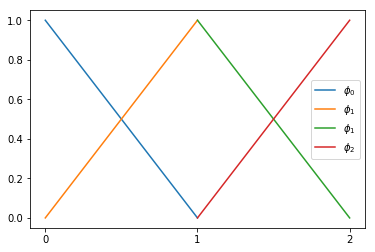

In [10]:
"""La base des éléments finis de Lagrange (P1)"""
xmin = 0
xmax = 2
Nel = 2
plot_P1(xmin,xmax,Nel)

## Question 4:

### Calcul de la matrice des éléments finis:

On a: $$A = (A_{i,j} )_{i,j} = \big( \int _{[xmin,xmax]}φ'_i φ'_j +φ_i φ_j\big)_{i,j} \\
= \big(\sum_{k=1}^{Nel-1} \int _{[x_k,x_{k+1}]}φ'_i φ'_j +φ_i φ_j\big)_{i,j}$$

Au lieu de calculer la valeur de A pour chaque (i,j) on se ramène au calcul sur chaque élément.En plus A est symétrique de la définition du produit scalaire donc pour chaque élément $E_k$ on a la base de Lagrange s'écrivant sous la forme:
$$\hat φ(x) = \left ( \begin{array}{cc}  0 \\ \vdots \\0\\φ_k \\φ_{k+1} \\ 0 \\\vdots \\ 0 \end{array}  \right )$$
Pour ne stocker que des valeurs non nulles on pose avec un un abus de notation:

$$\hat φ(x) = \left [ \begin{array}{cc}  φ_k \\φ_{k+1} \end{array}  \right ] = \frac {1} {h_k}\left [ \begin{array}{cc}  {x_{k+1}-x}\\{x-x_{k}} \end{array}  \right] \qquad ∀x ∈ E_k  $$

Et la dérivée est donc :

$$\hat φ'(x) = \left [ \begin{array}{cc}  φ'_k \\φ'_{k+1} \end{array}  \right ] = \frac {1} {h_k}\left [ \begin{array}{cc}  {-1}\\{+1} \end{array}  \right]  $$

Alors on a: 

$$ \color{blue} {A = (A_{i,j} )_{i,j} = \begin{cases} \frac {1} {h_{i-1}}+ \frac {1} {h_{i}}+\frac {h_{i-1} + h_{i}} {3} , &\mbox{if } i =j\\\frac {-1} {h_{i-1}}+\frac {h_{i-1}} {6} , &\mbox{if } i =j+1 \\\frac {-1} {h_{i}}+\frac {h_{i}} {6} , &\mbox{if } i =j-1\\ 0 &\mbox{sinon}\end{cases} \qquad ∀i,j ∈ [1,Ndof]} $$


In [11]:
"""class fem: Assemblage"""
class fem:

    def __init__(self, maillage):
        self.mesh =  maillage

    def matrixA_P1(self):
        """i=j"""
        diag = 1/self.mesh.h[:-1]+1/self.mesh.h[1:]+(self.mesh.h[1:]+self.mesh.h[:-1])/3
        """i=j+1"""
        diagsup = -1/self.mesh.h[1:-1] + self.mesh.h[1:-1]/6
        """i=j-1"""
        diaginf = -1/self.mesh.h[1:-1] + self.mesh.h[1:-1]/6
        A = spsp.diags([diag,diagsup,diaginf],[0,1,-1,],format="csr")
        return A


---
***N.B:***

La classe `mesh` contient 3 type de discitisation:

* Discritisation `np.linspace` equidistant.
* Discritisation `np.random.uniform` uniforme.
* Discritisation `np.random.rand` aléatoire.

Pour tester on a inclut une option 0,1 et 2 pour utiliser respectivement l'un des discritisation en dessus.

---

In [12]:
"""tester la methode matrixA_P1()"""
def testmatrixA_P1(maillage,disctisation=0):
    objet_mesh = maillage
    if(disctisation==1):
        mesh.init_uniform(objet_mesh)
    elif(disctisation==2):
        mesh.init_random(objet_mesh, 4,0,1)
    objet_fem = fem(objet_mesh)
    print("h: \n \n",objet_fem.mesh.h)
    print("\n\t\t---------------------\n")
    A = fem.matrixA_P1(objet_fem)
    print("la matrice d'assemblage A est: \n\n",A.todense())


In [13]:
"""testmatrixA_P1"""
maillage = mesh(3,2,0,1)
testmatrixA_P1(maillage,0)

h: 
 
 [0.3333333333 0.3333333333 0.3333333333]

		---------------------

la matrice d'assemblage A est: 

 [[ 6.2222222222 -2.9444444444]
 [-2.9444444444  6.2222222222]]


***Commentaire:***

---
On a $ u_1 = u_{n} = 0$ car on a conditions homogème, on a donc `Ndof = Nel - 1`. En effet si $u^h ∈ V_0^n$ alors les valeurs representatives de $u^h$ appelé degrée de liberté sont:

$$[u_2, u_3, . . . , u_{n−1}]$$

avec donc:  $$A \in \mathbf M_{Ndof}(\mathbb R)$$


On a la decomposition : 

$$ u^h = \sum_ {i = 1} ^n u_i = \sum_ {i = 2} ^{n-1} u_i \qquad ∀u^h ∈ V_0^n$$

---

## Question 5:

***Clacul du second membre:***

$$b = \big( \int _{[xmin,xmax]}f*φ_i \big)_{i} = \big(\sum_{k=1}^{Nel-1} \int _{[x_{k-1},x_{k+1}]}f*φ_i \big)_{i}$$

On rappel que:

$$ \color{black} {φ_i(x) = \begin{cases} \frac {x-x_{i-1}} {h_{i-1}}, &\mbox{if } i \in [x_{i-1},x_i]\\\frac {x_{i+1}-x} {h_{i}}, &\mbox{if } i \in [x_{i},x_{i+1}] \\ 0 &\mbox{sinon}\end{cases} }$$

Donc:

$$(b)_i = \int _{[x_i,x_{i+1}]}\big(f*\frac {x_{i+1}-x} {h_{i}}\big)_{i} + \int _{[x_{i-1},x_{i}]}\big(f*\frac {x-x_{i-1}} {h_{i-1}}\big)_{i} \qquad i \in [1,Ndof]$$

***Méthode de trapèze:***
La méthode de Trapèze approche $\int_{[a,b]} f$ par la somme:
$$ T_n(f) = h*\sum_0^{n-1} \frac {f(x_i)+f(x_{i+1})} {2} \qquad h = (b-a)/n$$
Si a et b sont proche (comme le cas des éléments) on peut estimer avec: $$ T_1(f) = h* \frac {f(a)+f(b)} {2} \qquad h = (b-a)$$

ce qui donne:
$$ \int _{[x_{i-1},x_{i+1}]}f(x)*φ_i(x) = \int _{[x_{i-1},x_{i}]}f(x)*φ_i(x) + \int _{[x_{i},x_{i+1}]}f(x)*φ_i(x)  \\
= h[i-1]*\frac {\big[f(x_{i-1})*φ_i(x_{i-1}) + f(x_{i})*φ_i(x_{i})\big]} {2} +  h[i]*\frac {\big[f(x_{i})*φ_i(x_{i}) + f(x_{i+1})*φ_i(x_{i+1})\big]} {2}  \\
= h[i-1]*\frac {\big[f(x_{i-1})* 1 + 0)\big]} {2} +  h[i]*\frac {\big[f(x_{i})*1 + 0\big]} {2}  
$$

Alors on a le terme second membre qui s'écrit:
$$\color{green}{(b)_i = \frac {h[i-1]*f(x_{i-1})+h[i]*f(x_{i})}{2} \qquad i \in [1,Ndof]}$$

In [14]:
"""class fem: Second membre"""
class fem:

    def __init__(self, maillage):
        self.mesh =  maillage

    def matrixA_P1(self):
        """i=j"""
        diag = 1/self.mesh.h[:-1]+1/self.mesh.h[1:]+(self.mesh.h[1:]+self.mesh.h[:-1])/3
        """i=j+1"""
        diagsup = -1/self.mesh.h[1:-1] + self.mesh.h[1:-1]/6
        """i=j-1"""
        diaginf = -1/self.mesh.h[1:-1] + self.mesh.h[1:-1]/6
        A = spsp.diags([diag,diagsup,diaginf],[0,1,-1,],format="csr")
        return A
    
    def rhs_P1(self,f): #f doit etre un foncteur
        b = np.zeros(self.mesh.Ndof)
        h = self.mesh.h.copy()
        x = self.mesh.nodes.copy()
        F = f(x)
        b[:] = h[:-1]*F[:-2]/2 + h[1:]*F[1:-1]/2
        return b


In [15]:
"""test de la méthode rhs_P1()"""
def testrhs_P1(maillage,f,discritisation=0):
    objet_mesh = maillage
    if(discritisation==1):
        mesh.init_uniform(objet_mesh)
    elif(discritisation==2):
        mesh.init_random(objet_mesh, maillage.Nel,maillage.xmin,maillage.xmax)
    objet_fem = fem(objet_mesh)
    print("h: \n \n",objet_fem.mesh.h)
    print("\n\t\t---------------------\n")
    A = fem.matrixA_P1(objet_fem)
    print("la matrice d'assemblage A est: \n\n",A.todense())
    print("\n\t\t---------------------\n")
    F = fem.rhs_P1(objet_fem,f)
    print("le vecteur second membre F est: \n\n",F)

In [16]:
"""appel de la fonction test"""
#definir le foncteur f = cst = 1
def f(x):
    return np.ones(len(x))

maillage = mesh(3,2,0,1)
testrhs_P1(maillage,f,0)
#testrhs_P1(maillage,f,1)
#testrhs_P1(maillage,f,2)

h: 
 
 [0.3333333333 0.3333333333 0.3333333333]

		---------------------

la matrice d'assemblage A est: 

 [[ 6.2222222222 -2.9444444444]
 [-2.9444444444  6.2222222222]]

		---------------------

le vecteur second membre F est: 

 [0.3333333333 0.3333333333]


## Question 6: Solution manufacturée

Afin de trouver `f(x)` on remplace la solution exacte $u_{exacte} = sin(\pi x)$ dans l'équation élliptique en bas:
    
$-u''(x) + u(x) = f(x)   \qquad \qquad sur \> ]0,1[ $

$u(0) = u(1) = 0.$

On a: $-sin(\pi x)'' = -\pi cos(\pi x)'= \pi ^2 sin(\pi x) $
donc: $$f(x) = (1+\pi^2) \times sin(\pi x)$$

In [736]:
"""Définir le foncteur du second membre"""
def f_manif(x):
    return (1+np.pi**2)*np.sin(np.pi*x)

In [589]:
"""test foncteur"""
f(np.ones(3)*1/2)

array([1., 1., 1.])

## Question 7: Vérification

In [590]:
"""class fem: Solve"""
class fem:

    def __init__(self, maillage):
        self.mesh =  maillage

    def matrixA_P1(self):
        """i=j"""
        diag = 1/self.mesh.h[:-1]+1/self.mesh.h[1:]+(self.mesh.h[1:]+self.mesh.h[:-1])/3
        """i=j+1"""
        diagsup = -1/self.mesh.h[1:-1] + self.mesh.h[1:-1]/6
        """i=j-1"""
        diaginf = -1/self.mesh.h[1:-1] + self.mesh.h[1:-1]/6
        A = spsp.diags([diag,diagsup,diaginf],[0,1,-1,],format="csr")
        return A
    
    def rhs_P1(self,f): #f doit etre un foncteur
        b = np.zeros(self.mesh.Ndof)
        h = self.mesh.h.copy()
        x = self.mesh.nodes.copy()
        F = f(x)
        b = h[:-1]*F[:-2]/2 + h[1:]*F[1:-1]/2
        return b
    
    def solve(self, f, plot=True):
        nel = self.mesh.Nel
        u_fem = np.zeros(nel+1)
        A = fem.matrixA_P1(self)
        b = fem.rhs_P1(self,f)
        u_fem[1:-1] = np.array(spsolve(A,b))[:]
        
        if(plot):
            fig,ax = plt.subplots(1)
            ax.plot(self.mesh.nodes,u_fem,"*-",label=" Solution MEF ")
            x = np.linspace(0,1,100)
            ax.plot(x,np.sin(np.pi*x),"-",label=r" Solution exacte: $sin(\pi x)$")
            ax.legend()
            ax.set_title("Solution approché par MEF à "+str(nel)+" éléments")
            return u_fem,ax
        else:
            return u_fem


In [591]:
"""tester la méthode solve()"""
def testsolve(maillage,f,discritisation=0):
    objet_mesh = maillage
    if(discritisation==1):
        mesh.init_uniform(objet_mesh)
    elif(discritisation==2):
        mesh.init_random(objet_mesh, maillage.Nel,maillage.xmin,maillage.xmax)
    objet_fem = fem(objet_mesh)
    #print("h: \n \n",objet_fem.mesh.h)
    #print("\n\t\t---------------------\n")
    A = fem.matrixA_P1(objet_fem)
    #print("la matrice d'assemblage A est: \n\n",A.todense())
    #print("\n\t\t---------------------\n")
    F = fem.rhs_P1(objet_fem,f)
    #print("le vecteur second membre F est: \n\n",F)
    #print("\n\t\t---------------------\n")
    U_exact = np.sin(np.pi *objet_mesh.nodes)
    print("la solution manifacturée U_exact est: \n\n",U_exact)
    print("\n\t\t---------------------\n")
    U_fem , ax= fem.solve(objet_fem,f)
    print("la solution fem U_fem est: \n\n",U_fem)

la solution manifacturée U_exact est: 

 [0.           0.8660254038 0.8660254038 0.          ]

		---------------------

la solution fem U_fem est: 

 [0.           0.6323917016 0.8035435842 0.          ]


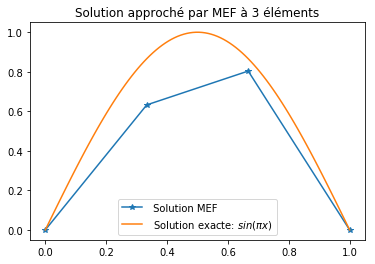

In [592]:
"""test solve"""
maillage = mesh(3,2,0,1)
testsolve(maillage,f_manif,0)
#testsolve(maillage,f_manif,1)
#testsolve(maillage,f_manif,2)

***Commentaire:***

Soit $\pi_h(u)$ le polynome d'interpolation des solutions MEF.
On a la convergence est directement liée au maillage sous l'inégalité suivante:
$$ \| u-\pi_{h}(u) \| _{L^2(\Omega)} \leq h^2 \|u''\|_{L^2(\Omega)}$$

C’est-à-dire que l'erreur tend vers 0 si la finesse du maillage tend elle aussi vers 0.

Pour atteindre ceci, le graphe en dessous l'illustre en jouant sur les points suivants:
* Un grand nombre d'élément
* Une discritisation `bien distribué`.

La question est mieux traité en question 9.


In [593]:
"""verification"""
def testverification(maillage,f,discritisation=0):
    objet_mesh = maillage
    if(discritisation==1):
        mesh.init_uniform(objet_mesh)
    elif(discritisation==2):
        mesh.init_random(objet_mesh, maillage.Nel,maillage.xmin,maillage.xmax)
    objet_fem = fem(objet_mesh)
    u_fem,ax = fem.solve(objet_fem,f)
    return u_fem,ax   

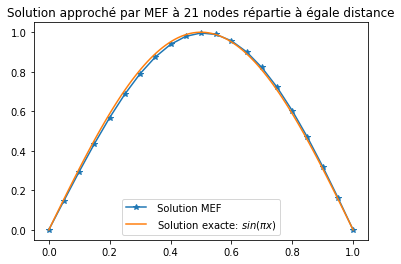

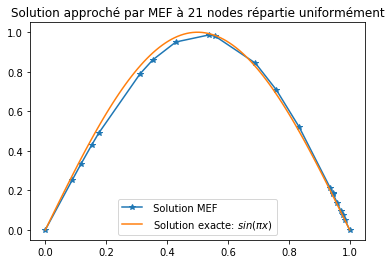

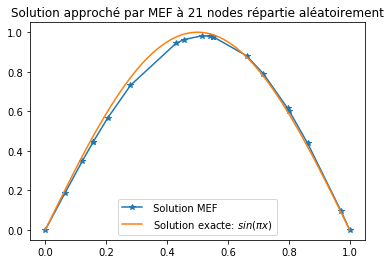

In [595]:
"""pour 20 éléments d'éléments"""
nel = 20
ndof = nel -1
maillage = mesh(nel,ndof,0,1)
u_fem,ax = testverification(maillage,f_manif,0)
ax.set_title("Solution approché par MEF à "+str(nel+1)+" nodes répartie à égale distance");
u_fem,ax = testverification(maillage,f_manif,1)
ax.set_title("Solution approché par MEF à "+str(nel+1)+" nodes répartie uniformément");
u_fem,ax = testverification(maillage,f_manif,2)
ax.set_title("Solution approché par MEF à "+str(nel+1)+" nodes répartie aléatoirement");

Wall time: 79 ms


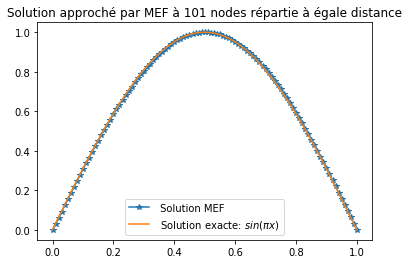

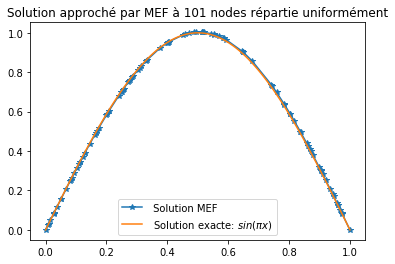

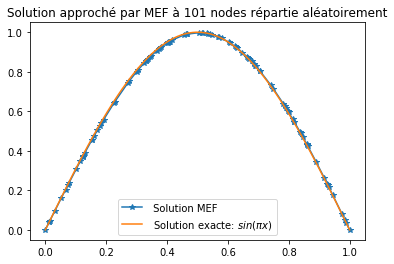

In [599]:
%%time
"""pour 101 nodes """
nel = 100
ndof = nel -1
maillage = mesh(nel,ndof,0,1)
u_fem,ax = testverification(maillage,f_manif,0)
ax.set_title("Solution approché par MEF à "+str(nel+1)+" nodes répartie à égale distance");
u_fem,ax = testverification(maillage,f_manif,1)
ax.set_title("Solution approché par MEF à "+str(nel+1)+" nodes répartie uniformément");
u_fem,ax = testverification(maillage,f_manif,2)
ax.set_title("Solution approché par MEF à "+str(nel+1)+" nodes répartie aléatoirement");

# Partie 2: Etude

***Rappel:***

On rappel que:
* $$\|u\|_{\mathbf L^2(\Omega)} = \sqrt {\sum _{i=1}^{(Nel+1)}\int _{[x_{i-1},x_{i}]}u^2(x)  }$$
* $$\|u\|_{\mathbf H^1(\Omega)} = \sqrt {\sum _{i=1}^{Nel+1}\int _{[x_{i-1},x_{i}]}(u^2(x)+u'^2(x))  }$$

On calcule ces normes en utilisant la méthode des Trapèzes comme la question 5.

* $$ \|u\|_{\mathbf L^2(\Omega)}
= \sqrt{\sum _{i=1}^{(Nel+1)}\big(h[i-1]*\frac {\big[u^2(x_{i-1}) + u^2(x_{i}))\big]} {2}\big )} 
$$

* $$ \|u\|_{\mathbf H^1(\Omega)}
= \sqrt {\sum _{i=1}^{(Nel+1)}\big (h[i-1]*\frac {\big[u^2(x_{i-1}) + u^2(x_{i}))\big]} {2} + h[i-1]*\frac {\big[u'^2(x_{i-1}) + u'^2(x_{i}))\big]} {2}\big ) }
$$

Pour estimer $u'$ on utilise la formule ci dessous:

$$u'_{i-1} = \frac {u(x_{i}) - u(x_{i-1})}{h_{i-1}} \qquad \forall i \in [1,Nel]$$.

## Question 8:

In [847]:
"""class fem: Solve"""
class fem:

    def __init__(self, maillage):
        self.mesh =  maillage

    def matrixA_P1(self):
        """i=j"""
        diag = 1/self.mesh.h[:-1]+1/self.mesh.h[1:]+(self.mesh.h[1:]+self.mesh.h[:-1])/3
        """i=j+1"""
        diagsup = -1/self.mesh.h[1:-1] + self.mesh.h[1:-1]/6
        """i=j-1"""
        diaginf = -1/self.mesh.h[1:-1] + self.mesh.h[1:-1]/6
        A = spsp.diags([diag,diagsup,diaginf],[0,1,-1,],format="csr")
        return A
    
    def rhs_P1(self,f): #f doit etre un foncteur
        b = np.zeros(self.mesh.Ndof)
        h = self.mesh.h.copy()
        x = self.mesh.nodes.copy()
        F = f(x)
        b = h[:-1]*F[:-2]/2 + h[1:]*F[1:-1]/2
        return b
    
    def solve(self, f, plot=True):
        
        """Solution exacte discrete"""
        x_i = self.mesh.nodes
        u_exact_i = np.sin(np.pi*x_i) 
        
        """Solution MEF"""
        nel = self.mesh.Nel
        u_fem = np.zeros(nel+1)
        A = fem.matrixA_P1(self)
        b = fem.rhs_P1(self,f)
        u_fem[1:-1] = np.array(spsolve(A,b))[:]
        u_err_L2,u_err_H2 = fem.norm_P1(self, (u_fem-u_exact_i))
        if(plot):
            x = np.linspace(0,1,100)
            u_exact = np.sin(np.pi*x)
            fig,ax = plt.subplots(1)
            ax.plot(self.mesh.nodes,u_fem,"*-",label=" Solution MEF ")
            ax.plot(x, u_exact,"-",label=r" Solution exacte: $sin(\pi x)$")
            ax.legend()
            ax.set_title("Solution approché par MEF à "+str(nel)+" éléments")
            return u_fem,u_err_L2,ax
        else:
            return u_fem,u_err_L2
        
    def norm_P1(self, u):

        h = self.mesh.h.copy()
        u_d = np.ones(len(u)-1)
        u_d[:] = (u[1:]-u[:-1])/h[:]
        
        L2 = h[:-1]*u[:-2]*u[:-2]/2 + h[1:]*u[1:-1]*u[1:-1]/2 
        H1 = L2 + h[:-1]*u_d[:-1]*u_d[:-1]/2 + h[1:]*u_d[1:]*u_d[1:]/2 
        
        norm_L2 = np.sqrt(np.sum(L2))
        norm_H1 = np.sqrt(np.sum(H1))
        
        return norm_L2,norm_H1


***Test sur le calcul des normes $L^2$ et $H^1$:***

In [848]:
"""tester la méthode norm_P1"""
def testnorm_P1(maillage,u,discritisation=0):
    objet_mesh = maillage
    if(discritisation==1):
        mesh.init_uniform(objet_mesh)
    elif(discritisation==2):
        mesh.init_random(objet_mesh, maillage.Nel,maillage.xmin,maillage.xmax)
    objet_fem = fem(objet_mesh)
    L2,H1  = fem.norm_P1(objet_fem,u)
    return L2,H1

In [849]:
"""test norme de L2 et H1 de u = 1 """
nel = 1000
ndof = nel -1
maillage = mesh(nel,ndof,0,1)
u = np.ones(nel+1)
L2,H1 = testnorm_P1(maillage,u,discritisation=0)
print("la norme L2 de u = 1 est 1 ~ ", L2)
print("la norme H1 de u = 1 est 1 ~ ", H1)

la norme L2 de u = 1 est 1 ~  0.999499874937461
la norme H1 de u = 1 est 1 ~  0.999499874937461


***Test sur le renvoie de l'erreur en L2:***

In [850]:
"""test de la méthode solve() modifiée"""
def testsolve_erreur(maillage,f,discritisation=0):
    objet_mesh = maillage
    if(discritisation==1):
        mesh.init_uniform(objet_mesh)
    elif(discritisation==2):
        mesh.init_random(objet_mesh, maillage.Nel,maillage.xmin,maillage.xmax)
    objet_fem = fem(objet_mesh)
    u_fem,u_err_L2,ax = fem.solve(objet_fem,f)
    return u_fem,u_err_L2,ax 

 l'erreur en norme L2 entre la solution exacte et MEFà nodes répartie à égale distance est:  0.001273349652400812
 l'erreur en norme L2 entre la solution exacte et MEF à nodes répartie uniformément est:  0.002625525497069695
 l'erreur en norme L2 entre la solution exacte et MEF à nodes répartie aléatoirement est:  0.0026989416317949534


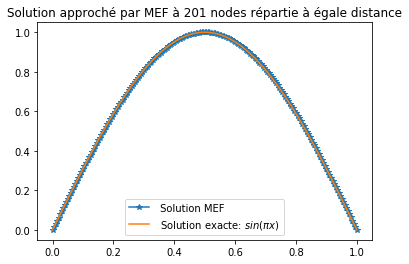

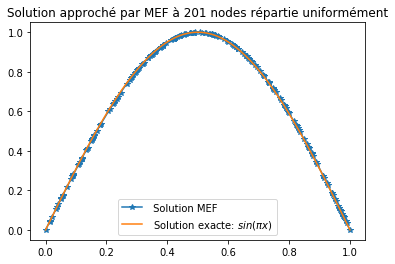

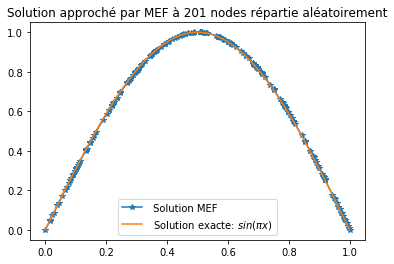

In [851]:
"""test méthode solve avec renvoie des erreurs en norme L2"""
nel = 200
ndof = nel -1
maillage = mesh(nel,ndof,0,1)
u_fem,u_err_L2,ax= testsolve_erreur(maillage,f_manif,0)
ax.set_title("Solution approché par MEF à "+str(nel+1)+" nodes répartie à égale distance");
print(" l'erreur en norme L2 entre la solution exacte et MEFà nodes répartie à égale distance est: ",u_err_L2)
u_fem,u_err_L2,ax = testsolve_erreur(maillage,f_manif,1)
ax.set_title("Solution approché par MEF à "+str(nel+1)+" nodes répartie uniformément");
print(" l'erreur en norme L2 entre la solution exacte et MEF à nodes répartie uniformément est: ",u_err_L2)
u_fem,u_err_L2,ax = testsolve_erreur(maillage,f_manif,2)
ax.set_title("Solution approché par MEF à "+str(nel+1)+" nodes répartie aléatoirement");
print(" l'erreur en norme L2 entre la solution exacte et MEF à nodes répartie aléatoirement est: ",u_err_L2)



## Question 9:

***Convergence:***

L'ordre de convergence attendue est donné par l'inégalité suivante:
$$ \| u-\pi_{h}(u) \| _{L^2(\Omega)} \leq h^2 \|u''\|_{L^2(\Omega)}$$

avec $h = \max h_j $ et puisque $ u = sin(\pi x)$ alors on a aussi $\|u''\|_{L^2(\Omega)} = \int_{[0,1]} \big(  \frac {1-cos(2\pi x)}{2}\big) = \frac 1 2$

Par suite on peut s'attendre à une erreur $L^2$: 

$$\| u-\pi_{h}(u) \| _{L^2(\Omega)} \leq \frac {h^2} {2}$$

    
    

In [852]:
"""L'ordre de convergence numérique"""
def test_convergence(maillage,f,discritisation=0):
    objet_mesh = maillage
    if(discritisation==1):
        mesh.init_uniform(objet_mesh)
    elif(discritisation==2):
        mesh.init_random(objet_mesh, maillage.Nel,maillage.xmin,maillage.xmax)
    objet_fem = fem(objet_mesh)
    u_fem,u_err_L2 = fem.solve(objet_fem,f,False)
    return u_fem,u_err_L2,objet_fem

"""pour le plot"""
def plot_convergence(nel,discritisation,ax):
    
    ndof = nel -1
    maillage = mesh(nel,ndof,0,1)
    u_fem,u_err_L2,objet_fem= test_convergence(maillage,f_manif,discritisation)
    
    h = np.max(objet_fem.mesh.h)
    err_theo = h*h/2
    
    ax.plot(h,u_err_L2,"o",label=" err num (Nel="+str(nel)+")")
    ax.plot(h,err_theo,"+",label=" err théo (Nel="+str(nel)+")")
    ax.set_yscale("log");
    ax.legend();
    ax.set_xlabel("Taille max des l'éléments")
    return ax

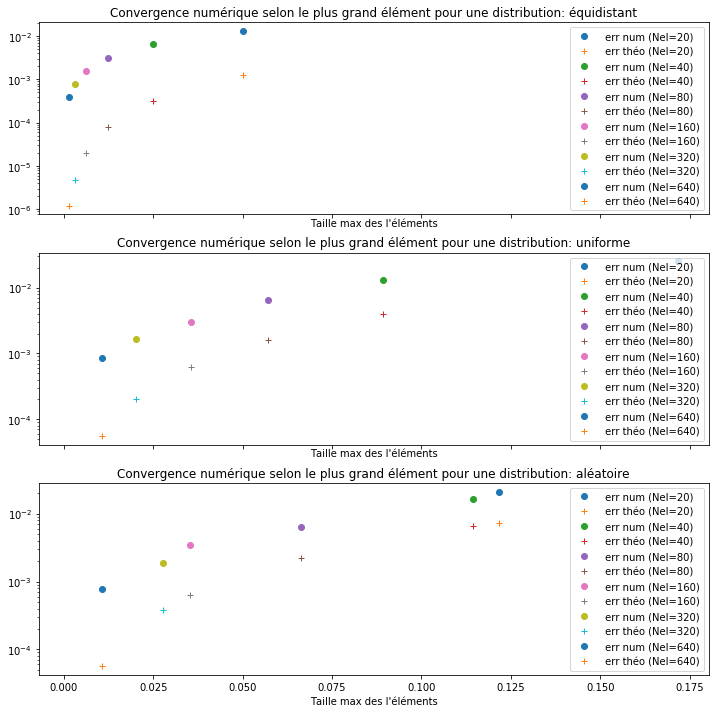

In [853]:
"""graphe de l'ordre de convergence numérique selon les discritisations et le nombre des éléments"""

Discritisation = ["équidistant","uniforme","aléatoire"]
fig,ax = plt.subplots(3,1,figsize=(12,12),sharex=True)
Nel = [20,40,80,160,320,640]
for i in range(3):
    for nel in Nel:
        ax[i] = plot_convergence(nel,i,ax[i])
    ax[i].set_title("Convergence numérique selon le plus grand élément pour une distribution: "+ Discritisation[i])

***Commentaire:***

Dans l'idéal l'erreur numérque doit être inférieur à $ {h^2} \times \|u''\|_{L^2}$ mais ce n'est pas le cas pour tous les discitisations étudiés.

En revanche on peut voir clairement que peu importe la discritisation, la convergence est garantie en augmentant le nombre d'éléments. La distribution équidistante ou (uniforme discrete) est la plus rapide et la plus précise car la taille maximale de l'élément est la plus petite comparément aux autres distributions. 



## Question 10:

In [854]:
"""L'ordre de convergence numérique"""
def test_conditionnement(maillage,discritisation=0):
    objet_mesh = maillage
    if(discritisation==1):
        mesh.init_uniform(objet_mesh)
    elif(discritisation==2):
        mesh.init_random(objet_mesh, maillage.Nel,maillage.xmin,maillage.xmax)
    objet_fem = fem(objet_mesh)
    A = fem.matrixA_P1(objet_fem)
    return np.linalg.cond(A.todense())

"""pour le plot"""
def plot_conditionnement(nel,discritisation,ax):
    
    ndof = nel -1
    maillage = mesh(nel,ndof,0,1)
    A_cond = test_conditionnement(maillage,discritisation)
    
    ax.plot(nel,A_cond,"o-")
    ax.set_yscale("log");
    ax.set_xlabel("Nombre d'éléments")
    return ax

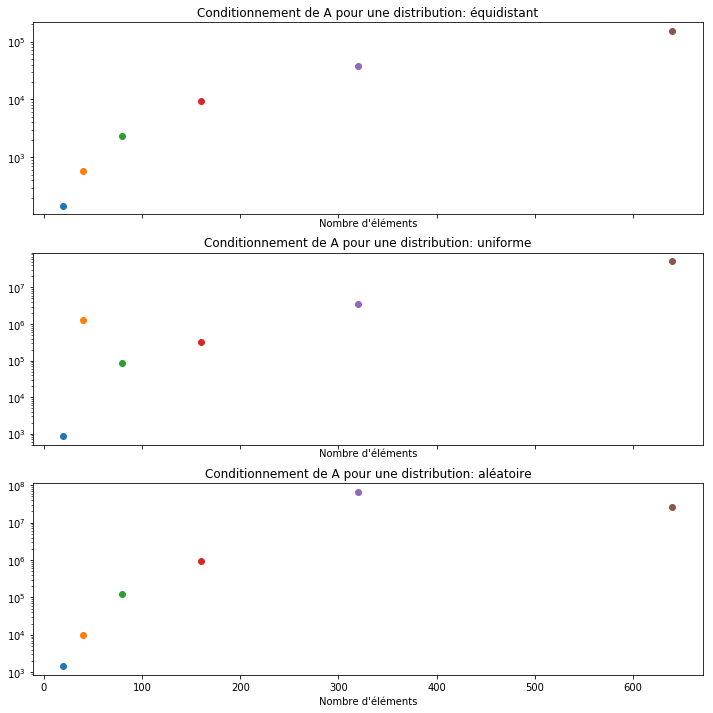

In [856]:
"""graphe de l'ordre de convergence numérique selon les discritisations et le nombre des éléments"""

Discritisation = ["équidistant","uniforme","aléatoire"]
fig,ax = plt.subplots(3,1,figsize=(12,12),sharex=True)
Nel = [20,40,80,160,320,640]
for i in range(3):
    for nel in Nel:
        ax[i] = plot_conditionnement(nel,i,ax[i])
    ax[i].set_title("Conditionnement de A pour une distribution: "+ Discritisation[i])

***Commentaire:***

Le conditionnement est trés grand pour le cas de distribution equidistant/ uniforme disctre $>10^2$ et encore plus pour le cas aléatoire ou uniforme continue $>10^3$. Ceci, éxplique le fait qu'on a pas trouvé les erreur$L^2$ attendus dans la question 9. Car un conditionnement trés grand implique une solution moins précise.

# Partie 3: Elément finis $\mathbb P_2$

## Question 11:

In [66]:
"""class mesh: discritisation"""
class mesh_P2:

    def __init__(self, Nel, deg,xmin,xmax):
        
        """ Partie P2"""
        self.Nel = Nel #le nombre d’éléments (sous-intervalles) du maillage
        self.xmin = xmin #point extrémal minimal
        self.xmax = xmax # point extrémal minimal
        self.nodes = np.linspace(xmin, xmax, Nel+1) #le tableau contenant les noeuds du maillage
        self.h = self.nodes[1:]-self.nodes[:-1]#le tableau contenant les tailles des mailles
        self.deg = deg # degree du polynome de lagrange
        self.Ndof = deg*Nel+1 #le nombre de degré de liberté P2
        self.dof = np.zeros(self.Ndof)


## Question 12: 

In [67]:
"""class mesh: discritisation"""
class mesh_P2:

    def __init__(self, Nel, deg,xmin,xmax):
        
        """ Partie P2"""
        self.Nel = Nel #le nombre d’éléments (sous-intervalles) du maillage
        self.xmin = xmin #point extrémal minimal
        self.xmax = xmax # point extrémal minimal
        self.nodes = np.linspace(xmin, xmax, Nel+1) #le tableau contenant les noeuds du maillage
        self.h = self.nodes[1:]-self.nodes[:-1]#le tableau contenant les tailles des mailles
        self.deg = deg # degree du polynome de lagrange
        self.Ndof = deg*Nel+1 #le nombre de degré de liberté P2
        self.dof = np.zeros(self.Ndof)
     
    """pour chaque numéro de l’élément et chaque numéro local du degré de liberté donne l’indice du degré de liberté associé"""
    def connect(self,el,k):
        
        i_dof = self.deg*el+k
        
        return i_dof


## Question 13:

In [68]:
"""class mesh: discritisation"""
class mesh_P2:

    def __init__(self, Nel, deg,xmin,xmax):
        
        """ Partie P2"""
        self.Nel = Nel #le nombre d’éléments (sous-intervalles) du maillage
        self.xmin = xmin #point extrémal minimal
        self.xmax = xmax # point extrémal minimal
        self.nodes = np.linspace(xmin, xmax, Nel+1) #le tableau contenant les noeuds du maillage
        self.h = self.nodes[1:]-self.nodes[:-1]#le tableau contenant les tailles des mailles
        self.deg = deg # degree du polynome de lagrange
        self.Ndof = deg*Nel+1 #le nombre de degré de liberté P2
        self.dof = np.zeros(self.Ndof)
    
    """pour chaque numéro de l’élément et chaque numéro local du degré de liberté donne l’indice du degré de liberté associé"""
    def connect(self,el,k):
        i_dof = self.deg*el+k
        return i_dof
        
    def init_uniform(self):
        self.nodes = np.sort(np.random.uniform(self.xmin, self.xmax, self.Nel+1))
        self.h = self.nodes[1:]-self.nodes[:-1]
        for j in range(self.Nel):
            for k in range(self.deg):
                self.dof[mesh_P2.connect(self,j,k)] = self.nodes[j] + self.h[j]*k/self.deg
        self.dof[-1] = self.xmax
        
    def init_random(self, Nel,xmin,xmax):
        self.nodes = np.sort(xmax*np.random.rand(Nel+1)+xmin)
        self.h = self.nodes[1:]-self.nodes[:-1]
        for j in range(self.Nel):
            for k in range(self.deg):
                self.dof[mesh_P2.connect(self,j,k)] = self.nodes[j] + self.h[j]*k/self.deg
        self.dof[-1] = self.xmax
                        

In [69]:
def testmesh_P2():
    objet_mesh = mesh_P2(3,3,0,1)
    mesh_P2.init_uniform(objet_mesh)
    print("\n\t\t----------uniforme-----------\n")
    print("Noeuds construit uniformement: \n \n ",objet_mesh.nodes)
    print("\n Tailles des mailles construit uniformement: \n \n ",objet_mesh.h)
    print("\n\t\t---------------------\n")
    print("Les degrees de libertés construit uniformement: \n \n ",objet_mesh.dof)
    mesh_P2.init_random(objet_mesh, 3,0,1)
    print("\n\t\t----------aléatoire-----------\n")
    print("Noeuds construit aleatoirement: \n \n ",objet_mesh.nodes)
    print("\n Tailles des mailles construit aleatoirement: \n \n ",objet_mesh.h)
    print("\n\t\t---------------------\n")
    print("Les degrees de libertés construit aleatoirement: \n \n ",objet_mesh.dof)

In [70]:
testmesh_P2()


		----------uniforme-----------

Noeuds construit uniformement: 
 
  [0.0861005249 0.323508545  0.5034464725 0.6245353433]

 Tailles des mailles construit uniformement: 
 
  [0.2374080201 0.1799379275 0.1210888708]

		---------------------

Les degrees de libertés construit uniformement: 
 
  [0.0861005249 0.1652365316 0.2443725383 0.323508545  0.3834878542 0.4434671633 0.5034464725 0.5438094295 0.5841723864 1.          ]

		----------aléatoire-----------

Noeuds construit aleatoirement: 
 
  [0.1540794483 0.2158248961 0.3489392071 0.6672288446]

 Tailles des mailles construit aleatoirement: 
 
  [0.0617454477 0.133114311  0.3182896375]

		---------------------

Les degrees de libertés construit aleatoirement: 
 
  [0.1540794483 0.1746612642 0.1952430801 0.2158248961 0.2601963331 0.3045677701 0.3489392071 0.4550357529 0.5611322987 1.          ]


## Question 16:

***Méthode de Simpson:***

La méthode de Simpson pproche $\int_{[a,b]} f$ par la formule:
 $$ T_1(f) = h* \big [\frac {f(a)+f(b)+4*f(\frac {a+b}{2})} {6}\big ] \qquad h = (b-a)$$

In [108]:
"""class mesh: discritisation"""
class mesh_P2:

    def __init__(self, Nel, deg,xmin,xmax):
        
        """ Partie P2"""
        self.Nel = Nel #le nombre d’éléments (sous-intervalles) du maillage
        self.xmin = xmin #point extrémal minimal
        self.xmax = xmax # point extrémal minimal
        self.nodes = np.linspace(xmin, xmax, Nel+1) #le tableau contenant les noeuds du maillage
        self.h = self.nodes[1:]-self.nodes[:-1]#le tableau contenant les tailles des mailles
        self.deg = deg # degree du polynome de lagrange
        self.Ndof = deg*Nel+1 #le nombre de degré de liberté P2
        self.dof = np.zeros(self.Ndof)
    
    """pour chaque numéro de l’élément et chaque numéro local du degré de liberté donne l’indice du degré de liberté associé"""
    def connect(self,el,k):
        i_dof = self.deg*el+k
        return i_dof
        
    def init_uniform(self):
        self.nodes = np.sort(np.random.uniform(self.xmin, self.xmax, self.Nel+1))
        self.h = self.nodes[1:]-self.nodes[:-1]
        for j in range(self.Nel):
            for k in range(self.deg):
                self.dof[mesh_P2.connect(self,j,k)] = self.nodes[j] + self.h[j]*k/self.deg
        self.dof[-1] = self.xmax
        
    def init_random(self, Nel,xmin,xmax):
        self.nodes = np.sort(xmax*np.random.rand(Nel+1)+xmin)
        self.h = self.nodes[1:]-self.nodes[:-1]
        for j in range(self.Nel):
            for k in range(self.deg):
                self.dof[mesh_P2.connect(self,j,k)] = self.nodes[j] + self.h[j]*k/self.deg
        self.dof[-1] = self.xmax
        
    def norm_P2(self, u):
        h = self.h.copy()
        L2 = 0
        for i in range(self.Nel):
            L2 += h[i]*(u[mesh_P2.connect(self,i,0)]**2+4*u[mesh_P2.connect(self,i,1)]**2+u[mesh_P2.connect(self,i,2)]**2)/6
        
        norm_L2 = np.sqrt(np.sum(L2))
        
        return norm_L2
                        

In [109]:
def test_norme_P2():
    objet_mesh = mesh_P2(3,3,0,1)
    mesh_P2.init_uniform(objet_mesh)
    print("\n\t\t----------test de norme L2-----------\n")
    print("La norme L2 de f(x) = x sur [0,1]est: \n \n ", mesh_P2.norm_P2(objet_mesh, objet_mesh.dof))

In [110]:
test_norme_P2()


		----------test de norme L2-----------

La norme L2 de f(x) = x sur [0,1]est: 
 
  0.2892818193815383


***Faute de temps les questions 14, 15, 17 et la question facultative n'ont pas été traités!***